### Imports

In [1]:
%load_ext autoreload
%autoreload 2
#%matplotlib notebook
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# custom packages
from ratsimulator import trajectory_generator
from ratsimulator.Environment import Rectangle

import datetime
import sys
# avoid adding multiple relave paths to sys.path
sys.path.append("../src") if "../src" not in sys.path else None 

from PlaceCells import PlaceCells
from Models import SorscherRNN
from methods import *

### Set parameters and initialise

In [3]:
"""
# Sorscher params
options.save_dir = '/mnt/fs2/bsorsch/grid_cells/models/'
options.n_steps = 100000      # number of training steps
options.batch_size = 200      # number of trajectories per batch
options.sequence_length = 20  # number of steps in trajectory
options.learning_rate = 1e-4  # gradient descent learning rate
options.Np = 512              # number of place cells
options.Ng = 4096             # number of grid cells
options.place_cell_rf = 0.12  # width of place cell center tuning curve (m)
options.surround_scale = 2    # if DoG, ratio of sigma2^2 to sigma1^2
options.RNN_type = 'RNN'      # RNN or LSTM
options.activation = 'relu'   # recurrent nonlinearity
options.weight_decay = 1e-4   # strength of weight decay on recurrent weights
options.DoG = True            # use difference of gaussians tuning curves
options.periodic = False      # trajectories with periodic boundary conditions
options.box_width = 2.2       # width of training environment
options.box_height = 2.2      # height of training environment
"""

params = {}
# Environment params
params['boxsize'] = (2.2, 2.2)
params['origo'] = (0,0)
params['soft_boundary'] = 0.2
# Place Cells params
params['npcs'] = 512 # as used in Sorscher model
params['pc_width'] = 0.12
params['DoG'] = True
params['seed'] = 0 # place-cell center seed
# Training data (Agent) params
params['batch_size'] = 200
params['seq_len'] = 20
params['angle0'] = None # random
params['p0'] = None     # random
# Agent/random walk parameters
params['dt'] = 0.02
params['turn_angle'] = 5.76 * 2
params['b'] = 0.13 * 2 * np.pi
params['mu'] = 0
# Model params
params['Ng'] = 4096
params['Np'] = params['npcs'] # defined for Brain already
params['weight_decay'] = 1e-4
params['lr'] = 1e-4# 1e-3 is default for Adam()
params['nsteps'] = 100 # number of mini batches in an epoch
params['nepochs'] = 1000 # number of epochs

# stuff
params['tag'] = 'default'
params['save_model'] = True 
params['save_freq'] = 1
params['date'] = datetime.datetime.now()

num_workers = 16
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
# Init Environment
environment = Rectangle(boxsize=params['boxsize'], soft_boundary=params['soft_boundary'])
params['environment_name'] = type(environment).__name__

# Init brain
place_cells = PlaceCells(environment=environment, **params)

# Init training data
dataset = Dataset(environment=environment, place_cells=place_cells, **params)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=params['batch_size'], num_workers=num_workers)

# Init model
model = SorscherRNN(Ng=params['Ng'], Np=params['Np']) 
model.to(device)
print(model)

# Init optimizer (use custom weight decay, rather than torch optim decay)
optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'], betas=(0.9, 0.999), \
                             eps=1e-08, weight_decay=0.0, amsgrad=False)

Singular matrix
Singular matrix
SorscherRNN(
  (init_position_encoder): Linear(in_features=512, out_features=4096, bias=False)
  (RNN): RNN(2, 4096, bias=False, batch_first=True)
  (decoder): Linear(in_features=4096, out_features=512, bias=False)
)


### Train Model

In [5]:
checkpoint_path = '../checkpoints/'
loss_history = []

if loaded_model:=True:
    model_name = type(model).__name__
    checkpoints = torch.load(f'{checkpoint_path}{model_name}_{params["tag"]}')
    model.load_state_dict(checkpoints['model_state_dict'])
    optimizer.load_state_dict(checkpoints['optimizer_state_dict'])
    loss_history = checkpoints['loss_history']
    training_metrics = checkpoints['training_metrics']
    print("Loaded weights")
    
# whether to train
if train:=False:
    loss_history = model.train(trainloader = dataloader, optimizer = optimizer, weight_decay=params['weight_decay'], \
                nepochs=params['nepochs'], loaded_model = loaded_model, \
                save_model = params['save_model'], save_freq = params['save_freq'], \
                loss_history = loss_history, tag = params['tag'], params = params)

Loaded weights


### Analyse Model

6.2383246250395095

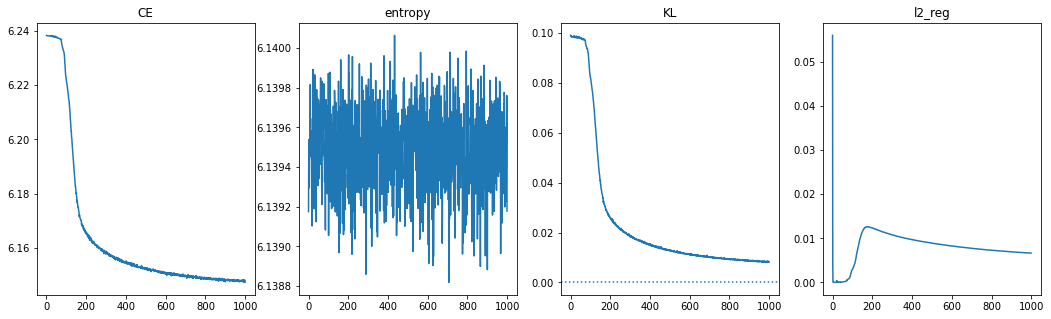

In [28]:
fig, ax = plt.subplots(ncols=4,figsize=(18,5))
for i,(key,value) in enumerate(checkpoints['training_metrics'].items()):
    if key == 'KL':
        ax[i].axhline(0,ls=":")
    ax[i].plot(value)
    ax[i].set_title(key)

# maximum labelled distribution entropy (uniform labelled distribution)
n = 512
px = np.ones(n) / n # uniform
entropy = lambda x: -np.sum(x * np.log(x))
entropy(px)

Text(0, 0.5, 'loss')

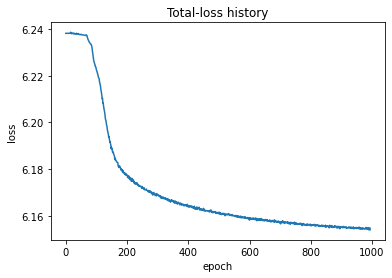

In [7]:
plt.plot(loss_history[5:])
plt.title('Total-loss history')
plt.xlabel('epoch')
plt.ylabel('loss')

### Grid cells

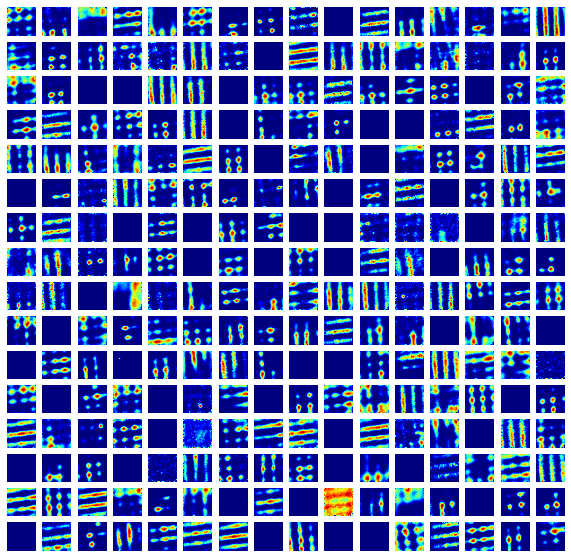

In [29]:
idxs=slice(64+16*16, 64+2*16*16, 1)
board, rate_maps, response_maps, count_maps = rate_map(model=model.g, environment=environment, dataset=dataset, seq_len=params['seq_len'], \
              res=np.array([32, 32]), idxs=idxs, num_samples=1)
num_response_maps = int((idxs.stop - idxs.start) / idxs.step)

#fig, ax = multicontourf(*board.T, rate_maps)
fig, ax = multiimshow(rate_maps)

### Predicted place Cells

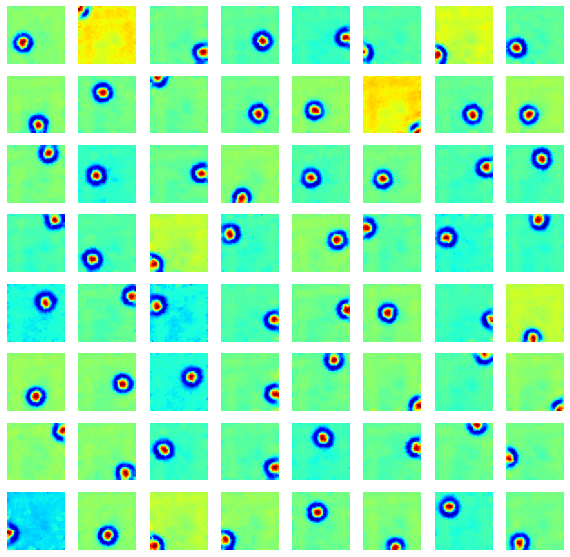

In [9]:
board, rate_maps, _, _ = rate_map(model=model, environment=environment, dataset=dataset, seq_len=params['seq_len'], \
              res=np.array([32, 32]), idxs=idxs, num_samples=1)
num_response_maps = int((idxs.stop - idxs.start) / idxs.step)

#fig, ax = multicontourf(*board.T, rate_maps)
fig, ax = multiimshow(rate_maps)

### Predicted Place cells - SOFTMAX

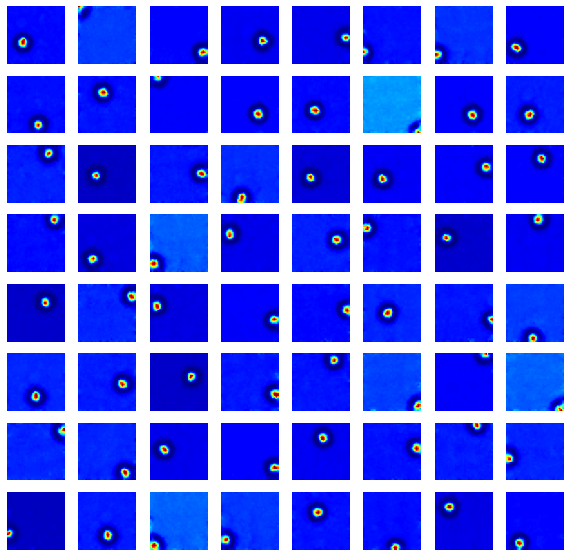

In [10]:
forward_with_softmax = lambda x: torch.exp(model(x, log_softmax=True))
board, rate_maps, _, _ = rate_map(model=forward_with_softmax, environment=environment, dataset=dataset, seq_len=params['seq_len'], \
              res=np.array([32, 32]), idxs=idxs, num_samples=1)
num_response_maps = int((idxs.stop - idxs.start) / idxs.step)

#fig, ax = multicontourf(*board.T, rate_maps)
fig, ax = multiimshow(rate_maps)

### Labelled place cells

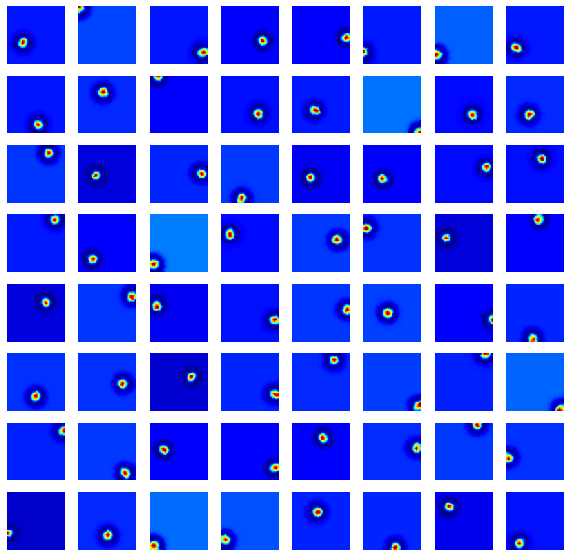

In [11]:
idxs=slice(0, 64, 1)
board, rate_maps, _, _ = rate_map(model='labels', environment=environment, dataset=dataset, seq_len=params['seq_len'], \
              res=np.array([32, 32]), idxs=idxs, num_samples=1)
num_response_maps = int((idxs.stop - idxs.start) / idxs.step)

#fig, ax = multicontourf(*board.T, rate_maps)
fig, ax = multiimshow(rate_maps)

### Decoding labels and predictions to cartesian

In [18]:
dataset.return_cartesian = True
[[vel, init_pos], labels, true_cartesian_pos] = dataset[0]
dataset.return_cartesian = False
true_decoded_pos = place_cells.to_euclid(torch.cat([init_pos[None], labels]))
pc_preds = model([vel, init_pos]).detach().cpu()[0]
predicted_decoded_pos = place_cells.to_euclid(torch.cat([init_pos[None], pc_preds]))

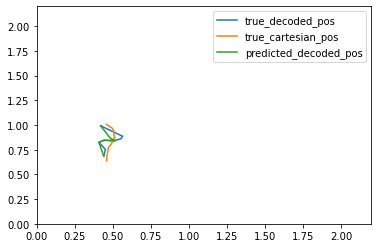

In [19]:
plt.plot(*true_decoded_pos.T, label='true_decoded_pos')
plt.plot(*true_cartesian_pos.T, label='true_cartesian_pos')
plt.plot(*predicted_decoded_pos.T, label='predicted_decoded_pos')
plt.xlim(environment.origo[0],environment.boxsize[0])
plt.ylim(environment.origo[1],environment.boxsize[1])
plt.legend()

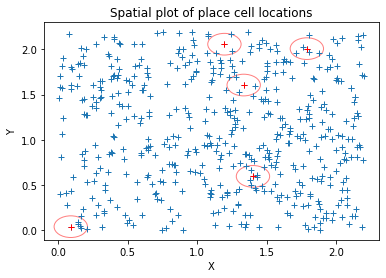

In [17]:
fig, ax = plt.subplots()
x,y = place_cells.pcs.T

ax.plot(x, y, "+")
# add standard deviation circles to locations
for i in range(5):
    ax.plot(x[i], y[i], "r+")
    a_circle = plt.Circle((x[i], y[i]), params['pc_width'], fill=False, color=(1, 0, 0, 0.5))
    ax.add_artist(a_circle)

plt.title("Spatial plot of place cell locations")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

In [ ]:
board = environment.get_board(res=(64,64))
br = brain.softmax_response(torch.tensor(board, dtype=torch.float32))
plt.imshow(br[...,5])
plt.colorbar()

In [ ]:
plt.imshow(br[...,300])
plt.colorbar()

In [ ]:
br[60,60,300]

In [ ]:
-(0.002 * np.log(0.002)) * 512

### Small analysis / checks / tests etc

In [ ]:
# Wr = model.recurrence.weight.detach().cpu().numpy()
Wr = model.RNN.weight_hh_l0.detach().cpu().numpy()
stats = lambda W : print(f"{np.min(W)=}, {np.max(W)=}, {np.min(abs(W))=}, {np.mean(W)=}, {np.std(W)=}, {np.sum(W**2)=}")
stats(Wr)
plt.imshow(Wr[:25,:25])
plt.colorbar()

In [ ]:
Wp = model.init_position_encoder.weight.detach().cpu().numpy()
stats = lambda W : print(f"{np.min(W)=}, {np.max(W)=}, {np.min(abs(W))=}, {np.mean(W)=}, {np.std(W)=}, {np.sum(W**2)=}")
stats(Wp)
plt.imshow(Wp)
plt.colorbar()